# **Avaliação 2** — Introdução ao Aprendizado de Máquina (ENGG67)
---

### **Docente:**
Antônio C. L. Fernandes Jr.

### **Discentes:**
- Beatriz Pereira Espinheira  
- Djair Maykon de Novaes Miranda

---

## **Questão1**


Utilizando o banco de dados [Breast Cancer Wisconsin (Diagnostic)](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) aborde o problema de classificação utilizando o algoritmo k-NN. Implemente o classificador em Jupyter
Notebook. Utilize o procedimento de validação cruzada para avaliar o seu resultado e todas
as medidas discutidas em sala para interpretar o resultado da classificação binária.

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo


breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

df = pd.concat([X, y], axis=1)


 ### **Normalização**
Como os métodos baseados em distância são diretamente afetados pela escala dos atributos, e os dados do dataset estão em escalas muito **diferentes**, é preciso promover uma **normalização dos dados** para minimizar esse problema.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X= scaler.fit_transform(X)
y = y.squeeze().values


---
## **Parte 1: Amostragem**
O método de amortragem escolhido foi o de **Validação Cruzada (𝑟-fold cross validation estratificado)**. <br/>
Na atividade anterior vimos que o conjunto de dados é levemente desbalanceado, Logo, essa variação do método de validação cruzada, por manter nas partições proporções semelhantes à do conjunto, é capaz de melhorar a capacidade preditiva do modelo.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [ ]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)  #transforma B e M em 0 e 1

#agrupa as classes no dataset (somente para vizualização)
sort_idx = np.argsort(y_encoded)
X_sorted = X[sort_idx]
y_sorted = y_encoded[sort_idx]

In [ ]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10, class_labels=["B", "M"]):
    n_samples = len(X)
    x_range = np.arange(n_samples)

    for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        indices = np.full(n_samples, np.nan)
        indices[train_idx] = 0
        indices[test_idx] = 1

        ax.scatter(x_range, [i + 0.5] * n_samples, c=indices, marker="_", lw=lw, cmap=plt.cm.plasma)

        y_test = y[test_idx]
        props = {class_labels[k]: v / len(y_test) for k, v in zip(*np.unique(y_test, return_counts=True))}
        ax.text(n_samples + 5, i + 0.5, " | ".join([f"{k}: {v:.1%}" for k, v in props.items()]), va="center", fontsize=9)

    ax.scatter(x_range, [-1] * n_samples, c=y, marker="_", lw=lw,
               cmap=ListedColormap(["#ff3366", "#94ff81"]))

    ax.set(
        yticks=np.append(np.arange(n_splits) + 0.5, -1),
        yticklabels=[f"{i+1}" for i in range(n_splits)] + ["Classe (B/M)"],
        xlabel="Índice da Amostra",
        ylabel="iteração do cv"
    )
    ax.set_xlim(0, n_samples + 100)
    ax.set_ylim(-2, n_splits + 2)

    legend = ax.legend(
        handles=[
            plt.Line2D([0], [0], color=plt.cm.plasma(0.), lw=4, label="Treino"),
            plt.Line2D([0], [0], color=plt.cm.plasma(1.), lw=4, label="Teste"),
            plt.Line2D([0], [0], color="#ff3366", lw=4, label="Classe B"),
            plt.Line2D([0], [0], color="#94ff81", lw=4, label="Classe M"),
        ],
        loc="upper left",
        title="Legenda:"
    )
    legend.get_title().set_fontsize(10)


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

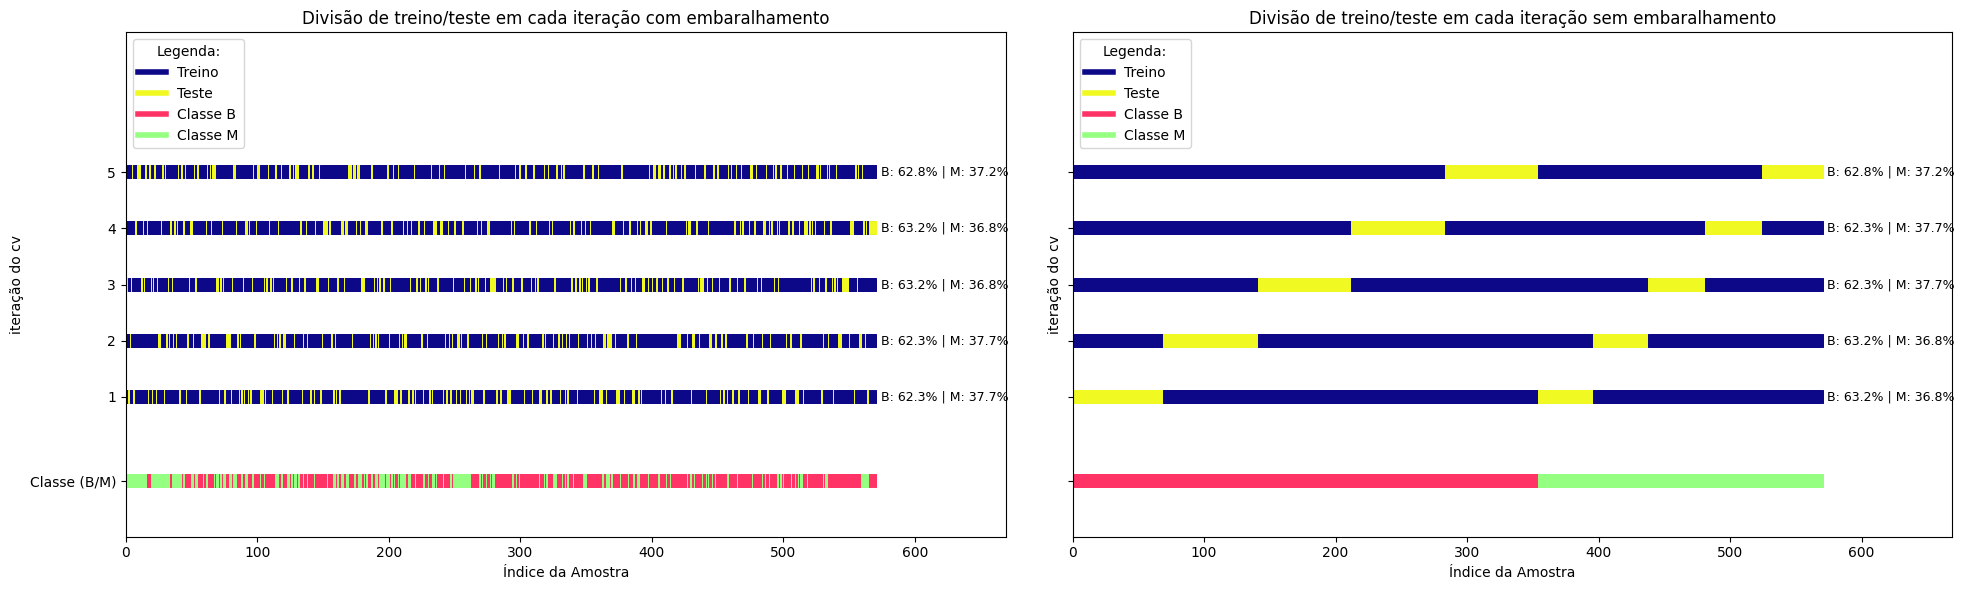

In [ ]:
cv2 = StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

#com shuffle
axes[0].set_title("Divisão de treino/teste em cada iteração com embaralhamento")
plot_cv_indices(cv, X, y_encoded, axes[0], n_splits=5)

#sem shuffle (apenas para mostrar o comportamento do r-fold estratificado)
axes[1].set_title("Divisão de treino/teste em cada iteração sem embaralhamento")
plot_cv_indices(cv2, X_sorted, y_sorted, axes[1], n_splits=5)


plt.tight_layout()
plt.show()

No **cross-validation estratificado com  r  folds**, a base de dados é dividida em *r* partições, mantendo a proporção entre as classes em cada uma delas.  
A cada iteração, *r-1* dessas partições são usadas para o **treinamento**, enquanto a parte restante é usada para o **teste**.  
Ao final, as métricas de desempenho do modelo são obtidas pela **média dos resultados** de todas as iterações, proporcionando uma avaliação mais confiável do modelo.


---
## **Parte 2: Implementando o k-NN**


O algoritmo **K-Nearest Neighbors (KNN)** é um método de classificação supervisionado baseado na distância entre os dados. Para classificar uma nova amostra, o KNN identifica os $k$ vizinhos mais próximos no conjunto de treinamento, com base em uma medida de distância (no nosso caso a Euclidiana), e atribui à nova amostra a classe mais frequente entre esses vizinhos.

A distância euclidiana entre dois pontos $x$ e $x_i$ é dada por:

$$
d(x, x_i) = \sqrt{ \sum_{j=1}^{n} (x_j - x_{ij})^2 }
$$

onde $n$ é o número de atributos (dimensões) dos dados.


In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

Vamos iniciar aplicando o algoritmo KNN com $k = 1$  para observar sua capacidade preditiva sobre os dados.


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)

y_pred = cross_val_predict(knn, X, y, cv=cv)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=5)
print(f"Acurácias em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f}")

[[347  10]
 [ 17 195]]
              precision    recall  f1-score   support

           B       0.95      0.97      0.96       357
           M       0.95      0.92      0.94       212

    accuracy                           0.95       569
   macro avg       0.95      0.95      0.95       569
weighted avg       0.95      0.95      0.95       569

Acurácias em cada fold: [0.94736842 0.96491228 0.97368421 0.92982456 0.9380531 ]
Acurácia média: 0.95


Podemos ver que o nosso modelo já obteve uma boa capacidade preditiva com k=1.
No entanto, podemos usar um método conhecido como **Método do Cotovelo** para escolher um valor melhor de _K_.

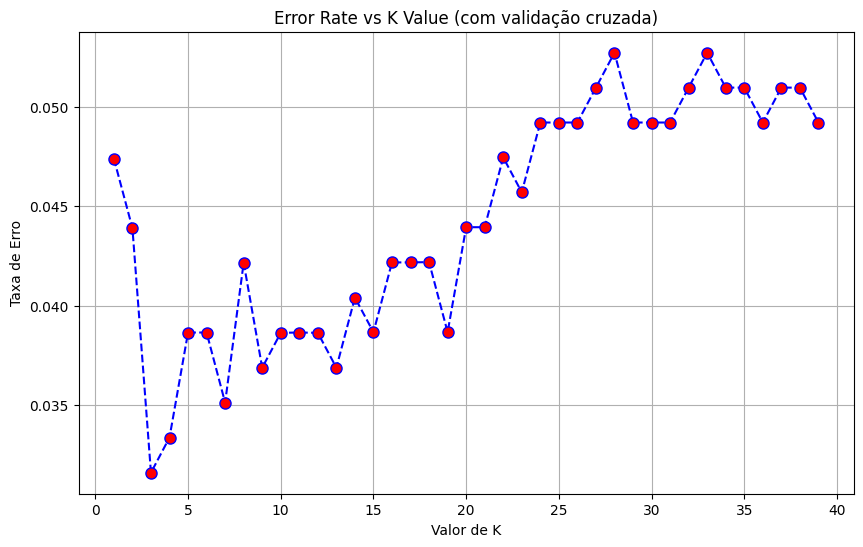

In [ ]:
error_rate = []

for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)

    scores = cross_val_score(knn, X, y, cv=cv)

    error = 1 - scores.mean()
    error_rate.append(error)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 40), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs K Value (com validação cruzada)')
plt.xlabel('Valor de K')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()



A partir dos gráficos é possível perceber que o modelo que obteve melhor capacidade preditiva tinha o parâmetro **K=3**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

y_pred = cross_val_predict(knn, X, y, cv=cv)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

from sklearn.model_selection import cross_val_score

scores = cross_val_score(knn, X, y, cv=cv)
print(f"Acurácia em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f}")

[[353   4]
 [ 14 198]]
              precision    recall  f1-score   support

           B       0.96      0.99      0.98       357
           M       0.98      0.93      0.96       212

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569

Acurácia em cada fold: [0.98245614 0.95614035 0.93859649 0.97368421 0.99115044]
Acurácia média: 0.97


---
## **Parte 3: Utilizando NCA**

Agora, para plotar os gráficos primeiro precisamos fazer uma redução de dimensionalidade. Para isso usaremos a técnica do **NCA (Neighborhood Components Analysis )** que é um algoritmo de aprendizado supervisionado para redução de dimensionalidade. <br/>

### Neighborhood Components Analysis (NCA)

Este é um método supervisionado que aprende uma transformação dos dados para melhorar o desempenho de classificadores baseados em vizinhos, como o KNN. Ele busca encontrar uma forma de projetar os dados em um espaço novo onde amostras da mesma classe fiquem mais próximas e amostras de classes diferentes fiquem mais distantes.

Para isso, o NCA define uma “probabilidade” de que uma amostra escolha outra como vizinha, e seu objetivo é maximizar a chance de que cada amostra selecione vizinhos da mesma classe. Essa otimização é feita por meio de métodos que ajustam a transformação até que essa condição seja satisfeita da melhor forma possível.

O resultado final é uma projeção supervisionada dos dados que pode ser usada para melhorar a acurácia de classificadores baseados em distâncias, facilitando a separação das classes no espaço reduzido.


Primeiro vamos **reajustar os valores de k** para esse novo modelo com redução de dimensionalidade, utilizando o _"elbow method"_

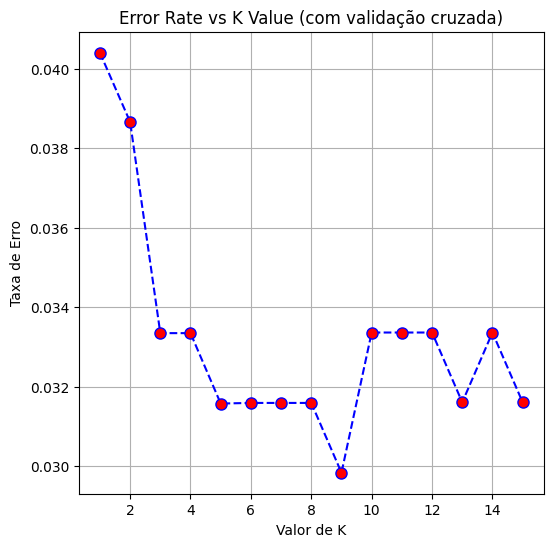

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline


error_rate = []

for k in range(1,16):
    nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=33)
    knn = KNeighborsClassifier(n_neighbors=k)
    model = make_pipeline(nca, knn)

    scores = cross_val_score(model, X, y, cv=cv)

    error = 1 - scores.mean()
    error_rate.append(error)

plt.figure(figsize=(6, 6))
plt.plot(range(1, 16), error_rate, color='blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=8)
plt.title('Error Rate vs K Value (com validação cruzada)')
plt.xlabel('Valor de K')
plt.ylabel('Taxa de Erro')
plt.grid(True)
plt.show()


Podemos perceber que o melhor valor foi **K=9** e que mesmo com a redução de dimensionalidade a acurácia foi aproximadamente igual a do modelo sem NCA e $k=3$ ( ambos com aproximadamente **97%**)

In [ ]:
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=33)
knn = KNeighborsClassifier(n_neighbors=9)
model = make_pipeline(nca, knn)

y_pred = cross_val_predict(model, X, y, cv=cv)

print(confusion_matrix(y, y_pred))
print(classification_report(y, y_pred))

scores = cross_val_score(model, X, y, cv=cv)
print(f"Acurácia em cada fold (KNN + NCA): {scores}")
print(f"Acurácia média (KNN + NCA): {np.mean(scores):.2f}")

[[354   3]
 [ 14 198]]
              precision    recall  f1-score   support

           B       0.96      0.99      0.98       357
           M       0.99      0.93      0.96       212

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569

Acurácia em cada fold (KNN + NCA): [0.98245614 0.97368421 0.94736842 0.95614035 0.99115044]
Acurácia média (KNN + NCA): 0.97


In [ ]:
train_index, test_index = next(cv.split(X, y))
X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

y_train, y_test = le.fit_transform(y_train), le.fit_transform(y_test)

nca.fit(X_train, y_train)
X_train_nca = nca.transform(X_train)
X_test_nca = nca.transform(X_test)


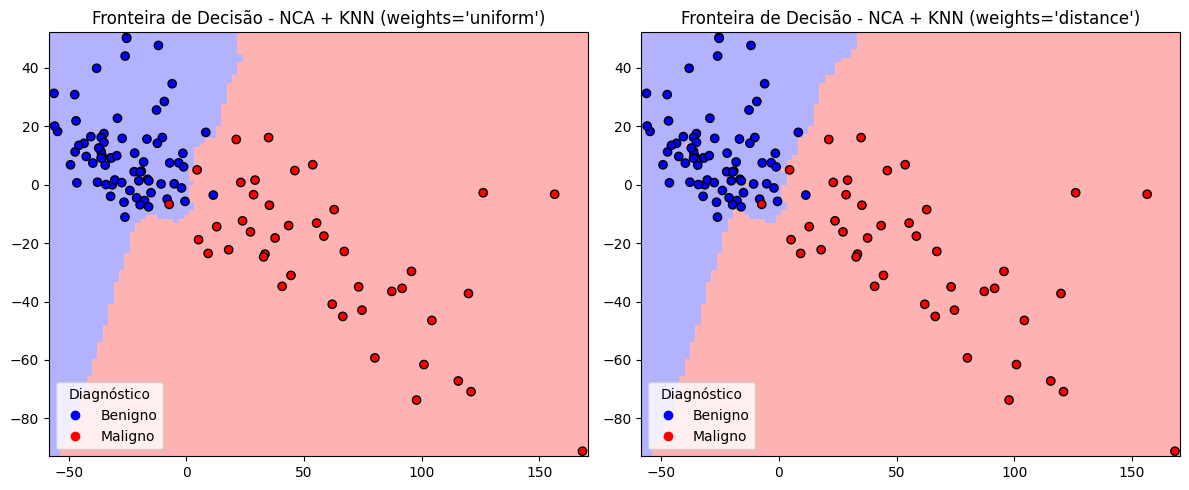

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

_, axs = plt.subplots(ncols=2, figsize=(12, 5))

for ax, weights in zip(axs, ("uniform", "distance")):
    knn = KNeighborsClassifier(n_neighbors=5, weights=weights)
    knn.fit(X_train_nca, y_train)

    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        X_test_nca,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        cmap='bwr',
        alpha=0.3,
        ax=ax,
    )

    scatter = disp.ax_.scatter(
        X_test_nca[:, 0],
        X_test_nca[:, 1],
        c=y_test,
        edgecolors="k",
        cmap='bwr',
    )

    disp.ax_.legend(
        scatter.legend_elements()[0],
        ['Benigno', 'Maligno'],
        loc="lower left",
        title="Diagnóstico",
    )
    ax.set_title(
        f"Fronteira de Decisão - NCA + KNN (weights='{weights}')"
    )

plt.tight_layout()
plt.show()

A partir dos gráficos podemos perceber o NCA conseguiu uma redução de dimensionalidade que distanciasse satisfatóriamente as duas classes.

No gráfico da esquerda está o NCA utilizando a forma **padrão**, ou seja, os pesos tipo 'uniform'. Nessa versão todos os 'n' vizinhos que definimos tem os mesmos pesos e os 'k' vizinhos contribuem igualmente para classificação da amostra.
Já na direita o tipo de peso é a **distância** 'distance' onde, entre os 'k' vizinhos, os vizinhos **mais próximos terão mais peso**.

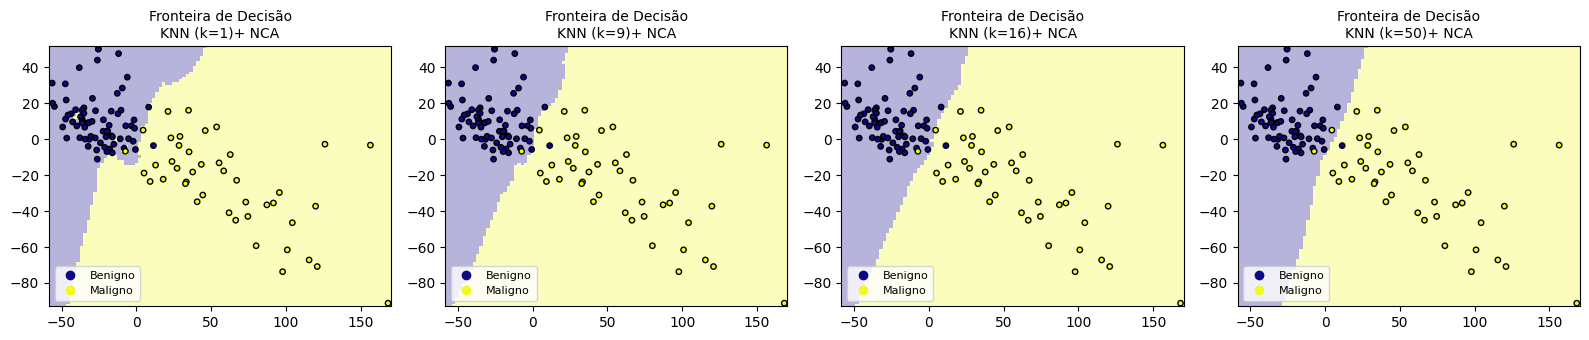

In [ ]:
k_values = [1, 9, 16, 50]

fig, axs = plt.subplots(1, 4, figsize=(16, 3.5))
axs = axs.flatten()

for ax, k in zip(axs, k_values):

    knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn.fit(X_train_nca, y_train)

    disp = DecisionBoundaryDisplay.from_estimator(
        knn,
        X_test_nca,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
        cmap='plasma',
        alpha=0.3,
        ax=ax,
    )

    scatter = ax.scatter(
        X_test_nca[:, 0],
        X_test_nca[:, 1],
        c=y_test,
        edgecolors="k",
        cmap='plasma',
        s=15
    )

    legend = ax.legend(
        scatter.legend_elements()[0],
        ['Benigno', 'Maligno'],
        loc="lower left",
        fontsize=8,
    )

    ax.set_title(f"Fronteira de Decisão\nKNN (k={k})+ NCA", fontsize=10)

plt.tight_layout()
plt.show()



**Conforme o valor de k aumenta** no k-NN, o modelo considera um número maior de vizinhos para tomar decisões, o que reduz a influência de pontos isolados ou ruídos. Isso faz com que a **fronteira de decisão fique mais suave** e retilínea, refletindo uma generalização melhor dos padrões dos dados. Em contrapartida, valores muito pequenos de k tornam a fronteira mais irregular, pois o modelo se ajusta demais às variações locais. Portanto, k atua como um controle de complexidade no k-NN.

---
## **Parte 5: Avaliação**
Voltando ao nosso modelo sem redução de dimensionalidade podemos avaliar seu desempenho utilizando as medidas discutidas em sala. De maneira geral podemos visualizar as métricas usando a função:  

In [ ]:
print(classification_report(y, y_pred))

scores = cross_val_score(model, X, y, cv=cv)
print(f"Acurácia em cada fold: {scores}")
print(f"Acurácia média: {np.mean(scores):.2f}")

              precision    recall  f1-score   support

           B       0.96      0.99      0.98       357
           M       0.99      0.93      0.96       212

    accuracy                           0.97       569
   macro avg       0.97      0.96      0.97       569
weighted avg       0.97      0.97      0.97       569

Acurácia em cada fold: [0.98245614 0.97368421 0.94736842 0.95614035 0.99115044]
Acurácia média: 0.97


A partir da função é possível perceber que para **classe B (benígno)**, aproximadamente:
* Precisão → 96% dos exemplos classificados como B estavam corretos
* Revocação → 99% dos casos reais de B foram corretamente identificados
* F1-score → 98% mostra equilíbrio entre precisão e recall

Já para a **classe M (malígno)**, aproximadamente:
* Precisão → 98% dos exemplos classificados como B estavam corretos
* Revocação → 93% dos casos reais de B foram corretamente identificados
* F1-score → 96% mostra equilíbrio entre precisão e recall

---
Para entender melhor cada medida de desempenho para problemas de duas classes, vamos calcular cada uma delas separadamente tomando a **classe positiva como os tumores malignos** e a **classe negativa como benignos** <br/>
$Positivo$ = Benigno <br/>
$Negativo$ = Maligno

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)

y_pred = cross_val_predict(model, X, y, cv=cv)

---
### **Matriz de Confusão**


In [ ]:
print(confusion_matrix(y, y_pred))

[[354   3]
 [ 14 198]]


A matriz de confusão demonstra que, para os tumores benígnos, houveram **353 verdadeiros negativos** (TN) e **4 falsos positivos** (FP). Ao mesmo tempo entre os malígnos houveram **14 falsos negativos** (FN) e **198 verdadeiros positivos** (TP). <br/>
* $TP$ = 198    (Verdadeiros Positivos)
* $TN$ = 353    (Verdadeiros Negativos)
* $FP$ = 4      (Falsos Negativos)
* $FN$ = 14     (Falsos Negativos)

---
### **Taxa de Erro Total**
$$
\text{err}(\hat{f}) = \frac{FP + FN}{n}
$$



In [ ]:
err = (4 + 14)/ (569)

print("A taxa de erro total foi de: ", err)

A taxa de erro total foi de:  0.03163444639718805


---
### **Acurácia**

$$
\text{Acurácia} = \frac{TP + TN}{TP + TN + FP + FN}
$$



In [ ]:
acuraccy = (198 + 353)/(353 + 198 + 4 + 14)

print("A acurácia foi de: ", acuraccy)

A acurácia foi de:  0.968365553602812


A acurácia de aproximadamente **97%** indica que o modelo está acertando **97%** das previsões o que indica, de forma geral, uma excelente capacidade preditiva.

---
### **Precisão**

$$
\text{Precisão} = \frac{TP}{TP + FP}
$$


In [ ]:
precision = (198)/(198 + 4)

print("A precisão foi de: ", precision)

A precisão foi de:  0.9801980198019802


A precisão de **98%** demonstra uma ótima taxa de acerto entre todas as previsões positivas (reais ou falsas)

---
### **Sensibilidade** ou Revocação
$$
\text{Sensibilidade} = \frac{TP}{TP + FN}
$$


In [ ]:
recall = (198)/(198 + 14)

print("A sensibilidade foi de: ", recall)

A sensibilidade foi de:  0.9339622641509434


A sensibilidade de aproximadamente **93%** demonstra uma boa capacidade de classificar corretamente os tumores malígnos (classe positiva).

---
### **Especificidade**
$$
\text{Especificidade} = \frac{TN}{TN + FP}
$$


In [ ]:
specificity = (353)/(353 + 4)

print("A especificidade foi de: ", specificity)

A especificidade foi de:  0.988795518207283


---
### **Fw-score** (Média Harmônica entre Precisão e Recall)

$$
F_1 = (w+1) \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
$$


### **F1-score**
Usando $w = 1$
$$
F_1 = 2 \cdot \frac{\text{Precisão} \cdot \text{Recall}}{\text{Precisão} + \text{Recall}}
$$
<br/>
o peso igual à 1 significa dar o **mesmo grau de importância à revocação e a precisão**, utilizaremos essa métrica para fins de simplicidade.

In [ ]:
f1_score = 2 * (precision * recall)/(precision + recall)

print("F1-score: ", f1_score)

F1-score:  0.9565217391304348


O f1-score de aproximadamente **96%** indica um **excelente equilíbrio entre precisão e recall**, ou seja, o knn está conseguindo prever corretamente a classe positiva com alta exatidão e completude. Isso é especialmente relevante no contexto de classificar tumores quanto a sua malignidade, onde é importante evitar tanto falsos positivos quanto falsos negativos.

---
## **Análise ROC**

<Figure size 600x500 with 0 Axes>

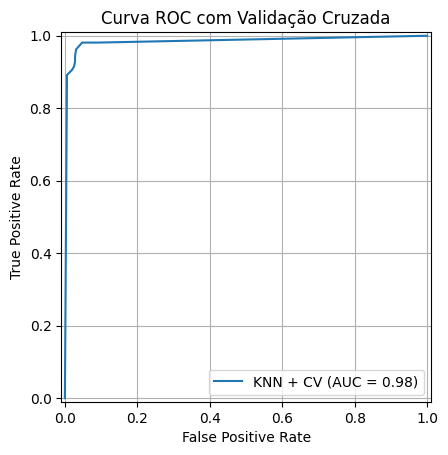

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

y_proba_cv = cross_val_predict(model, X, y_encoded, cv=5, method='predict_proba')[:, 1]

fpr, tpr, _ = roc_curve(y_encoded, y_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="KNN + CV").plot()
plt.title("Curva ROC com Validação Cruzada")
plt.grid(True)
plt.show()

Um **limiar de decisão** é o valor que determina a partir de qual probabilidade uma amostra será classificada como pertencente à classe positiva (nesse caso, tumores malignos). Por padrão, usa-se o valor 0,5, mas esse valor pode ser ajustado para aumentar a sensibilidade ou a especificidade do modelo, dependendo do contexto do problema.

O uso de diferentes limiares de decisão representa a maior ou menor **enfâse à classe positiva**, o que permite lidar melhor com questões como desbalanceamento das classes e de diferentes custos de classificação.

A **curva ROC** (Receiver Operating Characteristic) mostra como o desempenho do modelo muda conforme esse limiar é variado. Ela apresenta o **trade-off entre sensibilidade (taxa de verdadeiros positivos) e 1 - especificidade (taxa de falsos positivos)**, sendo útil em cenários onde os custos de erros (falsos positivos e falsos negativos) são diferentes, como é o caso da classificação de tumores.

No gráfico obtido, **a curva ROC se aproxima bastante do canto superior esquerdo**, o que indica que o KNN teve ótimo desempenho na separação entre as classes. Isso significa que ele é eficaz em identificar corretamente os positivos sem errar muito nos negativos.

A **AUC** (Área sob a Curva ROC) quantifica esse desempenho: um valor de **0.98 (ou 98%)** mostra que o modelo tem **excelente capacidade de distinguir entre as classes**, mesmo com diferentes limiares de decisão. Quanto mais próximo de 1, melhor o modelo é em discriminar entre positivos e negativos.

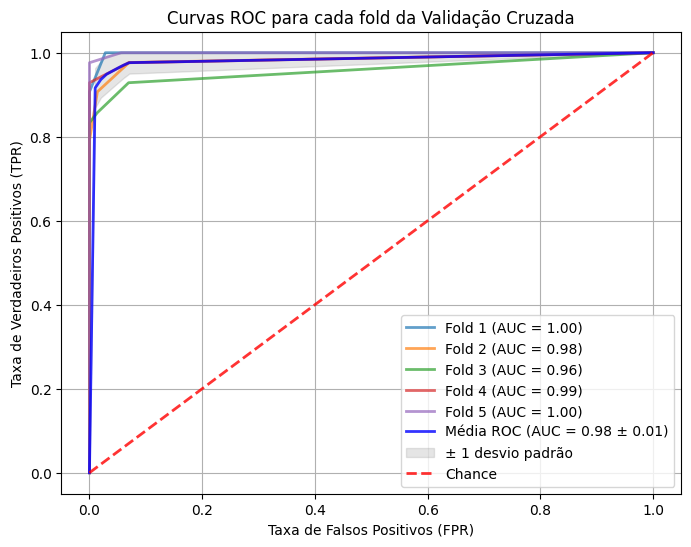

In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

for i, (train_index, test_index) in enumerate(cv.split(X, y_encoded)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    knn.fit(X_train, y_train)
    y_proba = knn.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)

    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)

    plt.plot(fpr, tpr, lw=2, alpha=0.7,
             label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

#média da curva ROC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='b',
         label=f'Média ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
         lw=2, alpha=0.8)

#intervalo de confiança ± std
std_tpr = np.std(tprs, axis=0)
tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tpr_lower, tpr_upper, color='grey', alpha=0.2,
                 label='± 1 desvio padrão')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=0.8)

plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curvas ROC para cada fold da Validação Cruzada')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

---
### **Referências**

FERNANDES JUNIOR, Antonio Carlos Lopes. **Avaliação de Modelos Preditivos.** 2025. Disponível em: https://ava.ufba.br/pluginfile.php/5406693/mod_resource/content/1/IAM_Avalia%C3%A7%C3%A3oDeModelosPreditivos_Cap10.pdf. Acesso em 10 mai. 2025

SCIKIT-LEARN. **scikit-learn: machine learning in Python — scikit-learn 0.20.3 documentation**. Disponível em: <https://scikit-learn.org/stable/index.html>. Acesso em 10 mai. 2025
